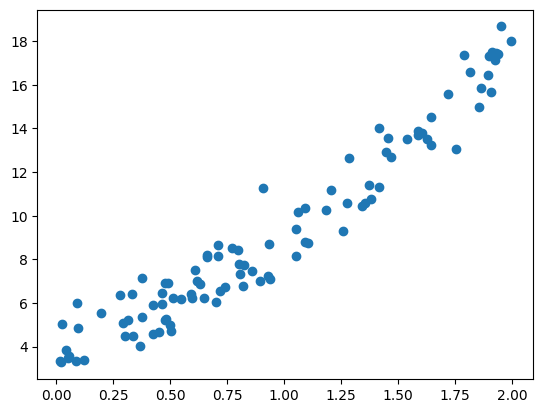

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, SGDRegressor
from numpy import asarray

# Make data
np.random.seed(67)
n = 100
X = 2 * np.random.rand(n, 1)

y = 4 + 3 * X + 2*X**2 + np.random.randn(n, 1)

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Splitting into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

# Plot data
plt.scatter(X,y)

# Hyperparameters
degree = 2 
batch_size = 8
epochs = 1000
decay1 = 0.9
decay2 = 0.999
epsilon = 1e-8
momentum = 0.9
decay_rate = 0.9

# OLS

### plain GD fixed learning rate to tune

The best model used eta = 0.01 with validation MSE = 1.0462.
Best Model Coefficients: [[3.98866452]
 [2.99709545]
 [1.94321081]]


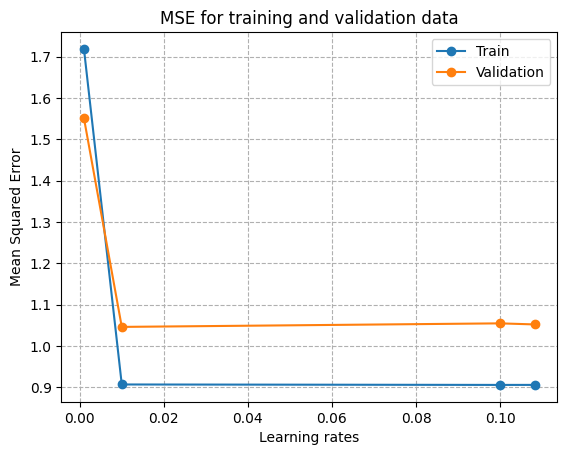

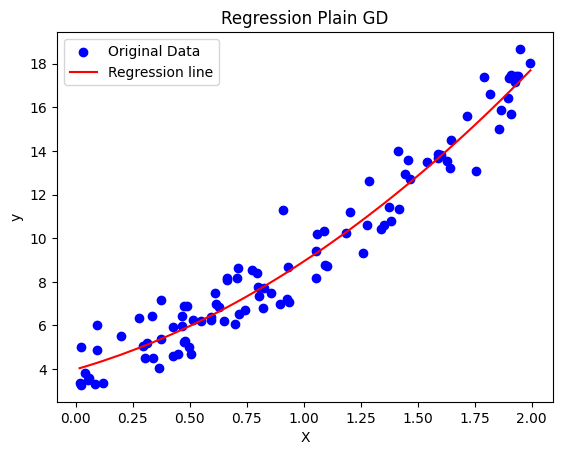

In [2]:
# by hand
def plain_GD(X_train, X_val, y_train, y_val, degree, epochs):

    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)


    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = sorted([0.001, 0.01, 0.1, 1.0 / np.max(EigValues)])

    mse_train = []
    mse_val = []
    
    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        for iter in range(epochs):
                          
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train)

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
                            
            # Update beta
            beta -= eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train.append(mean_squared_error(y_train, y_hat_train))
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val.append(mean_squared_error(y_val, y_hat_val))
    
        # Save the best model based on validation MSE
        if mse_val[-1] < min_mse_val:
            min_mse_val = mse_val[-1]
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print("Best Model Coefficients:", best_model)
    return best_model, mse_train, mse_val, learning_rates, poly

np.random.seed(32)
best_model, mse_train, mse_val, learning_rates, poly = plain_GD(X_train, X_val, y_train, y_val, degree, epochs)

# Plot 
plt.plot(learning_rates, mse_train, label="Train",marker='o')
plt.plot(learning_rates, mse_val, label="Validation",marker='o')
plt.xlabel("Learning rates")
plt.ylabel("Mean Squared Error")
plt.title("MSE for training and validation data")
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()


X_poly = poly.transform(X)  
y_pred = X_poly @ best_model 

sorted_indices = np.argsort(X, axis=0).ravel()  
X_sorted = X[sorted_indices]                    
y_pred_sorted = y_pred[sorted_indices]          

plt.scatter(X, y, color='blue', label='Original Data')
plt.plot(X_sorted, y_pred_sorted, color='red', label='Regression line')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Regression Plain GD")
plt.legend()
plt.show()

### with momentum

The best model used eta = 0.001 with validation MSE = 1.0531.
Best model coefficients: [[3.91399349]
 [3.19483618]
 [1.8524272 ]]


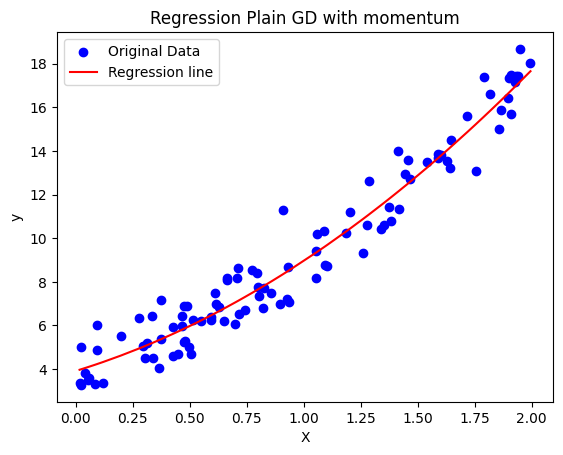

In [3]:
def plain_GD_with_momentum_OLS(X_train, X_val, y_train, y_val, degree, epochs, momentum=0.9):
    np.random.seed(32)

    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        change = np.zeros_like(beta)  # Initialize change for momentum
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train)

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            
            # Update beta using momentum
            new_change = eta * gradient + momentum * change
            beta = beta - new_change
            change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print("Best model coefficients:", best_model)
    return best_model,poly

np.random.seed(32)
best_model, poly = plain_GD_with_momentum_OLS(X_train, X_val, y_train, y_val, degree, epochs, momentum)

# plot
X_poly = poly.transform(X)  
y_pred = X_poly @ best_model  

sorted_indices = np.argsort(X, axis=0).ravel()  
X_sorted = X[sorted_indices]                   
y_pred_sorted = y_pred[sorted_indices]         

plt.scatter(X, y, color='blue', label='Original Data')
plt.plot(X_sorted, y_pred_sorted, color='red', label='Regression line')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Regression Plain GD with momentum")
plt.legend()
plt.show()

### Adagrad

The best model used eta = 0.1 with validation MSE = 1.0682.
Best model coefficients: [[3.63950001]
 [3.66212593]
 [1.68846342]]


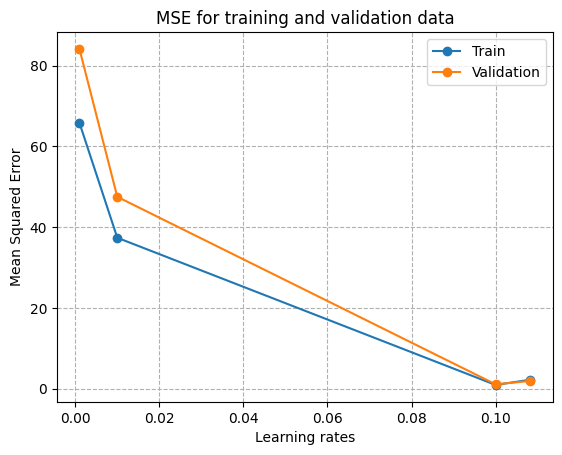

In [4]:
# Adagrad
def plain_Adagrad(X_train, X_val, y_train, y_val, degree, epochs):
    np.random.seed(32)

    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    mse_train = []
    mse_val = []

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train)

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            
            # Accumulate squared gradients
            accumulated_gradients += gradient ** 2
            
            # Compute adjusted learning rate
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
            
            # Update beta
            beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train.append(mean_squared_error(y_train, y_hat_train))
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val.append(mean_squared_error(y_val, y_hat_val))
    
        # Save the best model based on validation MSE
        if mse_val[-1] < min_mse_val:
            min_mse_val = mse_val[-1]
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print("Best model coefficients:", best_model)
    return best_model, mse_train , mse_val, learning_rates

np.random.seed(32)
best_model, mse_train, mse_val, learning_rates = plain_Adagrad(X_train, X_val, y_train, y_val, degree, epochs)

# Plot 
plt.plot(learning_rates, mse_train, label="Train",marker='o')
plt.plot(learning_rates, mse_val, label="Validation",marker='o')
plt.xlabel("Learning rates")
plt.ylabel("Mean Squared Error")
plt.title("MSE for training and validation data")
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

In [5]:
# Adagrad con momentum
def plain_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, epochs, momentum=0.1):
    np.random.seed(32)

    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        change = np.zeros_like(beta)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train)
            
            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            
            # Accumulate squared gradients
            accumulated_gradients += gradient ** 2
            
            # Compute adjusted learning rate
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
            
            # Update beta using momentum
            new_change = adjusted_eta * gradient + momentum * change
            beta = beta - new_change
            change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print("Best model coefficients:", best_model)
    return best_model

best_model = plain_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, epochs, momentum)

The best model used eta = 0.10827477457261722 with validation MSE = 1.0338.
Best model coefficients: [[4.20674867]
 [2.41298785]
 [2.21312526]]


### RMSprop

In [6]:
def plain_RMSprop(X_train, X_val, y_train, y_val, degree, epochs, decay_rate=0.9, epsilon=1e-8):

    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients for RMSprop
        accumulated_gradients = np.zeros_like(beta)
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train)

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            
            # Update the accumulated gradients with exponential decay
            accumulated_gradients = decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
            
            # Compute adjusted learning rate using the accumulated gradients
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + epsilon)
            
            # Update beta using RMSprop rule
            beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model

np.random.seed(32)
plain_RMSprop(X_train, X_val, y_train, y_val, degree, epochs, decay_rate, epsilon)

The best model used eta = 0.01 with validation MSE = 1.0503.


array([[3.90482416],
       [3.23782311],
       [1.83989679]])

In [7]:
# momentum
def plain_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, epochs, decay_rate=0.9, epsilon=1e-8, momentum=0.1):

    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        change = np.zeros_like(beta)
        
        # Initialize accumulated squared gradients for RMSprop
        accumulated_gradients = np.zeros_like(beta)
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train)

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            
            # Update the accumulated gradients with exponential decay
            accumulated_gradients = decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
            
            # Compute adjusted learning rate using the accumulated gradients
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + epsilon)
            
            # Update beta using momentum
            new_change = adjusted_eta * gradient + momentum * change
            beta = beta - new_change
            change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model

np.random.seed(32)
plain_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, epochs, decay_rate, epsilon, momentum)

The best model used eta = 0.01 with validation MSE = 1.0543.


array([[3.90280361],
       [3.2248373 ],
       [1.83858496]])

### ADAM

In [8]:
# Adam implementation with decay rates for moment estimates
def plain_Adam(X_train, X_val, y_train, y_val, degree, epochs, decay1=0.9, decay2=0.999, epsilon=1e-8):

    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize first moment vector and second moment vector
        first_moment = np.zeros_like(beta)  # First moment (mean of gradients)
        second_moment = np.zeros_like(beta)  # Second moment (mean of squared gradients)
        time_step = 0  # Time step

        for iter in range(epochs):
            time_step += 1  # Increment the time step
            
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train)
            
            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            
            # Update biased first moment estimate
            first_moment = decay1 * first_moment + (1 - decay1) * gradient
            
            # Update biased second raw moment estimate
            second_moment = decay2 * second_moment + (1 - decay2) * (gradient ** 2)
            
            # Correct bias in first moment
            first_moment_corrected = first_moment / (1 - decay1 ** time_step)
            # Correct bias in second moment
            second_moment_corrected = second_moment / (1 - decay2 ** time_step)

            # Update beta
            beta -= eta * first_moment_corrected / (np.sqrt(second_moment_corrected) + epsilon)
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model

np.random.seed(32)
plain_Adam(X_train, X_val, y_train, y_val, degree, epochs, decay1, decay2, epsilon)

The best model used eta = 0.10827477457261722 with validation MSE = 1.0438.


array([[4.01763166],
       [2.91962532],
       [1.97909798]])

## SGD (batch tutto)

In [9]:
# by hand true SGD 
def plain_SGD_hand(X_train, X_val, y_train, y_val, degree, epochs=100):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            # Iterate through each training example (SGD)
            for x_i, y_i in zip(X_train_poly_shuffled, y_train_shuffled):
                x_i = x_i.reshape(-1, 1) 

                # Calculate the gradient for the single example
                gradient = 2.0 * x_i @ (x_i.T @ beta - y_i)

                # Define a small tolerance for stopping condition
                tolerance = np.full_like(gradient, 0.0001)

                # Check if the gradient is small enough to stop early
                if np.all(np.abs(gradient) <= tolerance):
                    break

                # Update beta
                beta -= eta * gradient

        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)

        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print("Best Model Coefficients:", best_model)
    return best_model


np.random.seed(32)
best_model = plain_SGD_hand(X_train, X_val, y_train, y_val, degree, epochs)

The best model used eta = 0.001 with validation MSE = 1.0529.
Best Model Coefficients: [[3.90615208]
 [3.21712974]
 [1.84408036]]


In [10]:
# Scikit learn true SGD 
def plain_SGD(X_train, X_val, y_train, y_val, degree, epochs):
    best_model_coefficients = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train) 
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Create the SGDRegressor model with the specified learning rate
        sgdreg = SGDRegressor(max_iter=epochs, penalty=None, eta0=eta, learning_rate='constant', fit_intercept=False)
        sgdreg.fit(X_train_poly, y_train.ravel())
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = sgdreg.predict(X_train_poly)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = sgdreg.predict(X_val_poly)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model coefficients based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            # Concatenate intercept and coefficients into a single array
            best_model_coefficients = sgdreg.coef_
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print(f"Model coefficients: {best_model_coefficients}")
    return best_model_coefficients

np.random.seed(32)
plain_SGD(X_train, X_val, y_train, y_val, degree, epochs)

The best model used eta = 0.01 with validation MSE = 1.0302.
Model coefficients: [4.10575157 2.70320359 2.09409127]


array([4.10575157, 2.70320359, 2.09409127])

In [11]:
# by hand
def plain_SGD_with_mini_batches(X_train, X_val, y_train, y_val, degree, batch_size=32, epochs=100):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch)

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break

                # Update beta
                beta -= eta * gradient

        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)

        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print("Best Model Coefficients:", best_model)
    return best_model

np.random.seed(32)
best_model = plain_SGD_with_mini_batches(X_train, X_val, y_train, y_val, degree, batch_size, epochs)

The best model used eta = 0.01 with validation MSE = 1.0528.
Best Model Coefficients: [[3.92819553]
 [3.14922684]
 [1.87180672]]


### momentum

In [12]:
# MGD batch with momentum
def plain_SGD_with_momentum_OLS(X_train, X_val, y_train, y_val, degree, momentum=0.9, batch_size=32, epochs=100):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        change = np.zeros_like(beta)  # Initialize change for momentum
        
        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch)

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                # Update beta using momentum
                new_change = eta * gradient + momentum * change
                beta = beta - new_change
                change = new_change
                
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model

np.random.seed(32)
best_model = plain_SGD_with_momentum_OLS(X_train, X_val, y_train, y_val, degree, momentum, batch_size, epochs)
best_model

The best model used eta = 0.001 with validation MSE = 1.056.


array([[3.90507568],
       [3.21946728],
       [1.83747647]])

### minibatch scikit

In [13]:
# Scikit learn minibatch
def plain_SGD_with_batches(X_train, X_val, y_train, y_val, degree, batch_size=32, epochs=100):
    best_model_coefficients = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train) 
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize SGDRegressor with the specified learning rate
        sgdreg = SGDRegressor(max_iter=1, penalty=None, eta0=eta, learning_rate='constant', fit_intercept=False)
        
        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            # Iterate over mini-batches
            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]
                
                # Fit the model on the mini-batch
                sgdreg.partial_fit(X_batch, y_batch.ravel())

        # TRAIN - Calculate MSE for training data
        y_hat_train = sgdreg.predict(X_train_poly)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = sgdreg.predict(X_val_poly)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model coefficients based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model_coefficients = sgdreg.coef_
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print(f"Model coefficients: {best_model_coefficients}")
    return best_model_coefficients

np.random.seed(32)
best_model_coefficients = plain_SGD_with_batches(X_train, X_val, y_train, y_val, degree, batch_size, epochs)

The best model used eta = 0.001 with validation MSE = 1.0471.
Model coefficients: [3.99597882 2.97586982 1.95036741]


### Adagrad

In [14]:
# Adagrad no memntum
def SGD_Adagrad(X_train, X_val, y_train, y_val, degree, batch_size=32, epochs=100):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch)
                
                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients += gradient ** 2
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta
                beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model

np.random.seed(32)
best_model = SGD_Adagrad(X_train, X_val, y_train, y_val, degree, batch_size, epochs)
print("Best model coefficients:", best_model)

The best model used eta = 0.1 with validation MSE = 1.0459.
Best model coefficients: [[3.9889663 ]
 [2.9955825 ]
 [1.94436975]]


In [15]:
# con momentum 
# Adagrad 
def SGD_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, batch_size=32, epochs=100, momentum=0.9):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        # Initialize change for momentum
        change = np.zeros_like(beta)  

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch)

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients += gradient ** 2
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta using momentum
                new_change = adjusted_eta * gradient + momentum * change
                beta = beta - new_change
                change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model

np.random.seed(32)
best_model = SGD_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, batch_size, epochs, momentum)
print("Best model coefficients:", best_model)

The best model used eta = 0.01 with validation MSE = 1.0347.
Best model coefficients: [[4.06813644]
 [2.67325101]
 [2.11458737]]


### RMSprop


In [16]:
def SGD_RMSprop(X_train, X_val, y_train, y_val, degree, batch_size=32, epochs=100, decay_rate=0.9):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch)

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients =  decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta
                beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model

np.random.seed(32)
best_model = SGD_RMSprop(X_train, X_val, y_train, y_val, degree, batch_size, epochs, decay_rate)
print("Best model coefficients:", best_model)

The best model used eta = 0.01 with validation MSE = 1.0548.
Best model coefficients: [[3.90682906]
 [3.18392709]
 [1.85740976]]


In [17]:
# momentum
def SGD_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, batch_size=32, epochs=100, decay_rate=0.9, momentum=0.9):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        # Initialize change for momentum
        change = np.zeros_like(beta)  

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch)
                
                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients =  decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta using momentum
                new_change = adjusted_eta * gradient + momentum * change
                beta = beta - new_change
                change = new_change
                
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model

np.random.seed(32)
best_model = SGD_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, batch_size, epochs, decay_rate, momentum)
print("Best model coefficients:", best_model)

The best model used eta = 0.001 with validation MSE = 1.0562.
Best model coefficients: [[3.90331279]
 [3.22954453]
 [1.832616  ]]


### ADAM

In [18]:
# by hand
def SGD_ADAM(X_train, X_val, y_train, y_val, degree, batch_size=32, epochs=100, decay1=0.9, decay2=0.999, epsilon=1e-8):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)
    
    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    
    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        # Initialize first moment vector and second moment vector
        first_moment = np.zeros_like(beta)  # First moment (mean of gradients)
        second_moment = np.zeros_like(beta)  # Second moment (mean of squared gradients)
        time_step = 0  # Time step

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                time_step += 1
                
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch)

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Update biased first moment estimate
                first_moment = decay1 * first_moment + (1 - decay1) * gradient
                
                # Update biased second raw moment estimate
                second_moment = decay2 * second_moment + (1 - decay2) * (gradient ** 2)
                
                # Correct bias in first moment
                first_moment_corrected = first_moment / (1 - decay1 ** time_step)
                # Correct bias in second moment
                second_moment_corrected = second_moment / (1 - decay2 ** time_step)
    
                # Update beta
                beta -= eta * first_moment_corrected / (np.sqrt(second_moment_corrected) + epsilon)
            
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)

        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model

np.random.seed(32)
best_model = SGD_ADAM(X_train, X_val, y_train, y_val, degree, batch_size, epochs, decay1, decay2, epsilon)
print("Best Model Coefficients:", best_model)

The best model used eta = 0.1 with validation MSE = 1.0394.
Best Model Coefficients: [[3.90243973]
 [3.24268309]
 [1.87601915]]
